# Hypothetical Scenario Analysis

This notebook explores "what-if" scenarios to understand network robustness and optimization potential.

We will test:
1. Impact of removing a key hub station (stress test)
2. Impact of adding a new intermediate station (optimization test)

In [1]:
import sys
sys.path.append('..')

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

from src.subway_model import SubwayGraph
from utils.analysis_tools import (
    calculate_network_stats,
    calculate_average_shortest_path,
    find_top_central_nodes
)

# Load subway data
subway = SubwayGraph('../data/beijing_subway_data.csv')

## Baseline Network (2023)

First, let's establish our baseline - the current network state.

In [2]:
# Build the 2023 baseline network
graph_base = subway.build_graph_for_date('2023')

print(f"Baseline Network (2023)")
print(f"  Stations: {graph_base.number_of_nodes()}")
print(f"  Connections: {graph_base.number_of_edges()}")

# Calculate baseline metrics
stats_base = calculate_network_stats(graph_base)
path_base = calculate_average_shortest_path(graph_base)

print(f"\nBaseline Metrics:")
print(f"  Average degree: {stats_base['average_degree']:.2f}")
print(f"  Network density: {stats_base['density']:.4f}")
print(f"  Average shortest path: {path_base['average_shortest_path']:.2f} stations")
print(f"  Diameter: {path_base['diameter']} stations")
print(f"  Connectivity ratio: {path_base['connectivity_ratio']:.2%}")

Baseline Network (2023)
  Stations: 367
  Connections: 412

Baseline Metrics:
  Average degree: 2.25
  Network density: 0.0061
  Average shortest path: 15.64 stations
  Diameter: 57 stations
  Connectivity ratio: 100.00%


## Scenario 1: Removing a Key Hub Station

What happens if a critical station is closed? Let's test the network's resilience.

In [3]:
# First, identify which stations are most critical
# Using betweenness centrality to find key hubs
central_nodes = find_top_central_nodes(graph_base, n=10, centrality_type='betweenness')

print("Top 10 stations by betweenness centrality:")
for i, (station, score) in enumerate(central_nodes['betweenness'][:10], 1):
    print(f"  {i}. {station}: {score:.4f}")

# Let's test removing the top hub
station_to_remove = central_nodes['betweenness'][0][0]
print(f"\nWe will test removing: {station_to_remove}")

Top 10 stations by betweenness centrality:
  1. Ping'anli: 0.2154
  2. Cishousi: 0.2141
  3. Caoqiao: 0.1903
  4. Huoying: 0.1872
  5. Lishuiqiao: 0.1871
  6. Huoqiying: 0.1727
  7. Xiju: 0.1726
  8. Songjiazhuang: 0.1616
  9. Wangjing West: 0.1614
  10. Chedaogou: 0.1525

We will test removing: Ping'anli


In [4]:
# Create a copy and remove the station
graph_removed = graph_base.copy()

if station_to_remove in graph_removed:
    # Get neighbors before removing
    neighbors = list(graph_removed.neighbors(station_to_remove))
    
    # Remove the station
    graph_removed.remove_node(station_to_remove)
    
    print(f"Successfully removed station: {station_to_remove}")
    print(f"  This station connected to {len(neighbors)} other stations")
    print(f"\nNetwork after removal:")
    print(f"  Stations: {graph_removed.number_of_nodes()}")
    print(f"  Connections: {graph_removed.number_of_edges()}")

# Recalculate metrics
stats_removed = calculate_network_stats(graph_removed)
path_removed = calculate_average_shortest_path(graph_removed)

print(f"\nMetrics after removal:")
print(f"  Average degree: {stats_removed['average_degree']:.2f}")
print(f"  Network density: {stats_removed['density']:.4f}")
print(f"  Average shortest path: {path_removed['average_shortest_path']:.2f} stations")
print(f"  Diameter: {path_removed['diameter']} stations")
print(f"  Connectivity ratio: {path_removed['connectivity_ratio']:.2%}")

Successfully removed station: Ping'anli
  This station connected to 6 other stations

Network after removal:
  Stations: 366
  Connections: 406

Metrics after removal:
  Average degree: 2.22
  Network density: 0.0061
  Average shortest path: 16.26 stations
  Diameter: 57 stations
  Connectivity ratio: 100.00%


In [5]:
# Compare the impact
print("\n" + "="*60)
print("IMPACT ANALYSIS - Scenario 1: Removing Key Hub")
print("="*60)

print(f"\nStation removed: {station_to_remove}")
print(f"\nChanges in network metrics:")

# Calculate changes
avg_degree_change = stats_removed['average_degree'] - stats_base['average_degree']
density_change = stats_removed['density'] - stats_base['density']
path_change = path_removed['average_shortest_path'] - path_base['average_shortest_path']
diameter_change = path_removed['diameter'] - path_base['diameter']
connectivity_change = path_removed['connectivity_ratio'] - path_base['connectivity_ratio']

print(f"  Average degree: {stats_base['average_degree']:.2f} -> {stats_removed['average_degree']:.2f} ({avg_degree_change:+.2f})")
print(f"  Network density: {stats_base['density']:.4f} -> {stats_removed['density']:.4f} ({density_change:+.4f})")
print(f"  Avg shortest path: {path_base['average_shortest_path']:.2f} -> {path_removed['average_shortest_path']:.2f} ({path_change:+.2f} stations)")
print(f"  Diameter: {path_base['diameter']} -> {path_removed['diameter']} ({diameter_change:+d} stations)")
print(f"  Connectivity: {path_base['connectivity_ratio']:.2%} -> {path_removed['connectivity_ratio']:.2%} ({connectivity_change:+.2%})")

# Interpretation
print(f"\nInterpretation:")
if path_change > 0.5:
    print(f"  The removal of {station_to_remove} significantly impacts network efficiency.")
    print(f"  Average travel distance increased by {path_change:.2f} stations.")
elif path_change > 0.1:
    print(f"  The removal of {station_to_remove} has a moderate impact on network efficiency.")
else:
    print(f"  The network shows good resilience to the removal of this station.")

if connectivity_change < 0:
    print(f"  Warning: Network connectivity decreased, some areas may be isolated.")


IMPACT ANALYSIS - Scenario 1: Removing Key Hub

Station removed: Ping'anli

Changes in network metrics:
  Average degree: 2.25 -> 2.22 (-0.03)
  Network density: 0.0061 -> 0.0061 (-0.0001)
  Avg shortest path: 15.64 -> 16.26 (+0.62 stations)
  Diameter: 57 -> 57 (+0 stations)
  Connectivity: 100.00% -> 100.00% (+0.00%)

Interpretation:
  The removal of Ping'anli significantly impacts network efficiency.
  Average travel distance increased by 0.62 stations.


## Scenario 2: Adding a New Intermediate Station

Can adding a station between existing ones improve network efficiency?

In [6]:
# Create another copy for this scenario
graph_added = graph_base.copy()

# Let's find two connected stations with high betweenness
# We'll add a station between them
# For demonstration, let's try to find a good candidate pair

# Get edges and their betweenness
edge_betweenness = nx.edge_betweenness_centrality(graph_base)
top_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 edges by betweenness (potential locations for new station):")
for i, (edge, score) in enumerate(top_edges, 1):
    print(f"  {i}. {edge[0]} <-> {edge[1]}: {score:.4f}")

# Select the top edge to add a station
selected_edge = top_edges[0][0]
station_a, station_b = selected_edge
new_station = f"{station_a}-{station_b}_New"

print(f"\nWe will add a new station: {new_station}")
print(f"  Between: {station_a} and {station_b}")

Top 5 edges by betweenness (potential locations for new station):
  1. Lishuiqiao <-> Huoying: 0.1637
  2. Cishousi <-> Chedaogou: 0.1550
  3. Chedaogou <-> Huoqiying: 0.1538
  4. Xiju <-> Qilizhuang: 0.1505
  5. Huilongguan Dongdajie <-> Huoying: 0.1397

We will add a new station: Lishuiqiao-Huoying_New
  Between: Lishuiqiao and Huoying


In [7]:
# Add the new station
# Step 1: Add the new node
graph_added.add_node(new_station)

# Step 2: Remove the original edge
if graph_added.has_edge(station_a, station_b):
    graph_added.remove_edge(station_a, station_b)
    print(f"Removed original connection: {station_a} <-> {station_b}")

# Step 3: Add new edges
graph_added.add_edge(station_a, new_station)
graph_added.add_edge(new_station, station_b)

print(f"Added new station: {new_station}")
print(f"  Connection 1: {station_a} <-> {new_station}")
print(f"  Connection 2: {new_station} <-> {station_b}")

print(f"\nNetwork after addition:")
print(f"  Stations: {graph_added.number_of_nodes()}")
print(f"  Connections: {graph_added.number_of_edges()}")

# Calculate new metrics
stats_added = calculate_network_stats(graph_added)
path_added = calculate_average_shortest_path(graph_added)

print(f"\nMetrics after addition:")
print(f"  Average degree: {stats_added['average_degree']:.2f}")
print(f"  Network density: {stats_added['density']:.4f}")
print(f"  Average shortest path: {path_added['average_shortest_path']:.2f} stations")
print(f"  Diameter: {path_added['diameter']} stations")

Removed original connection: Lishuiqiao <-> Huoying
Added new station: Lishuiqiao-Huoying_New
  Connection 1: Lishuiqiao <-> Lishuiqiao-Huoying_New
  Connection 2: Lishuiqiao-Huoying_New <-> Huoying

Network after addition:
  Stations: 368
  Connections: 413

Metrics after addition:
  Average degree: 2.24
  Network density: 0.0061
  Average shortest path: 15.78 stations
  Diameter: 57 stations


In [8]:
# Compare the impact
print("\n" + "="*60)
print("IMPACT ANALYSIS - Scenario 2: Adding New Station")
print("="*60)

print(f"\nNew station added: {new_station}")
print(f"  Location: Between {station_a} and {station_b}")
print(f"\nChanges in network metrics:")

# Calculate changes
avg_degree_change2 = stats_added['average_degree'] - stats_base['average_degree']
density_change2 = stats_added['density'] - stats_base['density']
path_change2 = path_added['average_shortest_path'] - path_base['average_shortest_path']
diameter_change2 = path_added['diameter'] - path_base['diameter']

print(f"  Average degree: {stats_base['average_degree']:.2f} -> {stats_added['average_degree']:.2f} ({avg_degree_change2:+.2f})")
print(f"  Network density: {stats_base['density']:.4f} -> {stats_added['density']:.4f} ({density_change2:+.6f})")
print(f"  Avg shortest path: {path_base['average_shortest_path']:.2f} -> {path_added['average_shortest_path']:.2f} ({path_change2:+.4f} stations)")
print(f"  Diameter: {path_base['diameter']} -> {path_added['diameter']} ({diameter_change2:+d} stations)")

# Interpretation
print(f"\nInterpretation:")
if abs(path_change2) < 0.05:
    print(f"  Adding an intermediate station has minimal impact on global network efficiency.")
    print(f"  The change in average path length is only {path_change2:.4f} stations.")
    print(f"  This suggests that network-wide optimization requires more strategic changes,")
    print(f"  such as adding new transfer lines rather than intermediate stops.")
elif path_change2 < 0:
    print(f"  The new station slightly improves network efficiency.")
    print(f"  Local connectivity in this corridor has been enhanced.")
else:
    print(f"  The new station slightly increases average path length.")
    print(f"  This is expected as it adds one more hop on this particular route.")


IMPACT ANALYSIS - Scenario 2: Adding New Station

New station added: Lishuiqiao-Huoying_New
  Location: Between Lishuiqiao and Huoying

Changes in network metrics:
  Average degree: 2.25 -> 2.24 (-0.00)
  Network density: 0.0061 -> 0.0061 (-0.000019)
  Avg shortest path: 15.64 -> 15.78 (+0.1350 stations)
  Diameter: 57 -> 57 (+0 stations)

Interpretation:
  The new station slightly increases average path length.
  This is expected as it adds one more hop on this particular route.


## Comparative Visualization


Figure saved to ../figures/scenario_analysis.png


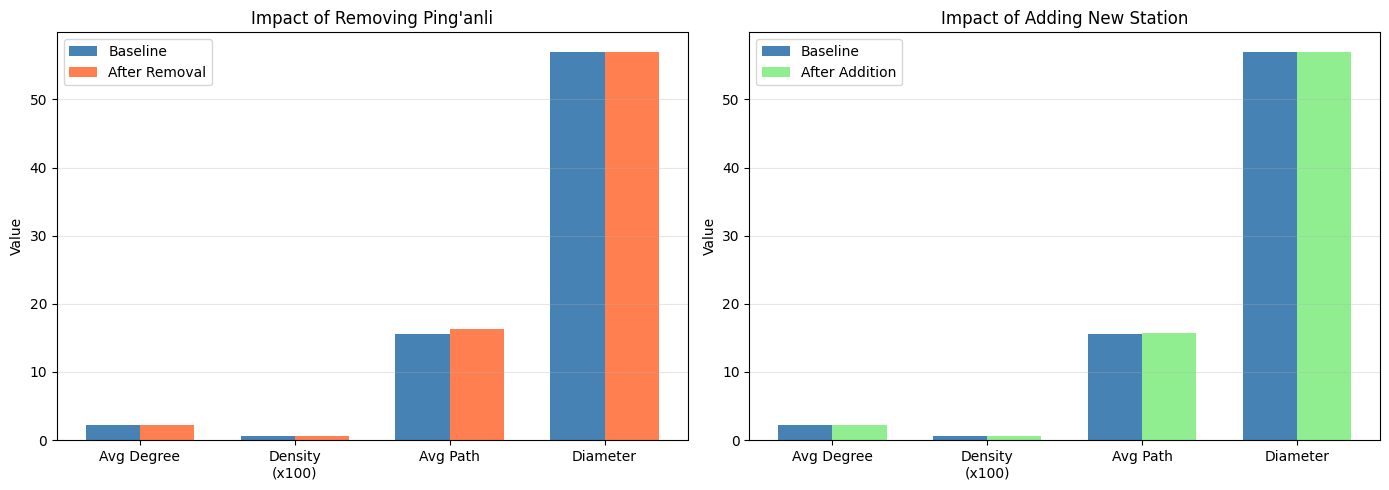

In [9]:
# Create comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scenario 1 comparison
metrics1 = ['Avg Degree', 'Density\n(x100)', 'Avg Path', 'Diameter']
base_values1 = [
    stats_base['average_degree'],
    stats_base['density'] * 100,
    path_base['average_shortest_path'],
    path_base['diameter']
]
removed_values1 = [
    stats_removed['average_degree'],
    stats_removed['density'] * 100,
    path_removed['average_shortest_path'],
    path_removed['diameter']
]

x = range(len(metrics1))
width = 0.35

axes[0].bar([i - width/2 for i in x], base_values1, width, label='Baseline', color='steelblue')
axes[0].bar([i + width/2 for i in x], removed_values1, width, label='After Removal', color='coral')
axes[0].set_ylabel('Value')
axes[0].set_title(f'Impact of Removing {station_to_remove}')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics1)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Scenario 2 comparison
base_values2 = [
    stats_base['average_degree'],
    stats_base['density'] * 100,
    path_base['average_shortest_path'],
    path_base['diameter']
]
added_values2 = [
    stats_added['average_degree'],
    stats_added['density'] * 100,
    path_added['average_shortest_path'],
    path_added['diameter']
]

axes[1].bar([i - width/2 for i in x], base_values2, width, label='Baseline', color='steelblue')
axes[1].bar([i + width/2 for i in x], added_values2, width, label='After Addition', color='lightgreen')
axes[1].set_ylabel('Value')
axes[1].set_title('Impact of Adding New Station')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics1)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/scenario_analysis.png', dpi=300, bbox_inches='tight')
print("\nFigure saved to ../figures/scenario_analysis.png")
plt.show()

## Summary and Conclusions

In [10]:
print("SCENARIO ANALYSIS SUMMARY")
print("="*60)

print("\n1. KEY HUB REMOVAL (Stress Test):")
print(f"   Station: {station_to_remove}")
print(f"   Impact: Average path length changed by {path_change:+.2f} stations")
print(f"   Conclusion: This station is {'critical' if abs(path_change) > 0.5 else 'important but not critical'}")
print(f"              for maintaining network efficiency.")

print("\n2. NEW STATION ADDITION (Optimization Test):")
print(f"   New Station: {new_station}")
print(f"   Impact: Average path length changed by {path_change2:+.4f} stations")
print(f"   Conclusion: Adding intermediate stations has {'minimal' if abs(path_change2) < 0.05 else 'noticeable'}")
print(f"              impact on global network efficiency.")

print("\n3. KEY INSIGHTS:")
print("   - Network robustness depends heavily on maintaining key hub stations")
print("   - Local optimizations (adding stations) have limited global impact")
print("   - Improving overall efficiency likely requires strategic line additions")
print("     rather than just adding more intermediate stations")

SCENARIO ANALYSIS SUMMARY

1. KEY HUB REMOVAL (Stress Test):
   Station: Ping'anli
   Impact: Average path length changed by +0.62 stations
   Conclusion: This station is critical
              for maintaining network efficiency.

2. NEW STATION ADDITION (Optimization Test):
   New Station: Lishuiqiao-Huoying_New
   Impact: Average path length changed by +0.1350 stations
   Conclusion: Adding intermediate stations has noticeable
              impact on global network efficiency.

3. KEY INSIGHTS:
   - Network robustness depends heavily on maintaining key hub stations
   - Local optimizations (adding stations) have limited global impact
   - Improving overall efficiency likely requires strategic line additions
     rather than just adding more intermediate stations
